# Beaver Tutorial 3: Neural Network Training (Data Scientist)

Train a CNN on MNIST with privacy-preserving collaboration.

Run this alongside `03-neural-network-do.ipynb` in a separate tab.

## Step 1: Setup

In [1]:
!uv pip install torch torchvision matplotlib numpy -q

In [2]:
import beaver
from beaver import Twin
import time

bv = beaver.ctx()
session = bv.active_session()
session.reset(force=True)

print(f"You: {bv.user}")
print(f"Peer: {session.peer}")

🔄 Auto-load replies enabled for client2@sandbox.local (polling every 0.5s)
🟢 Active session loaded: d9efe11cc2d0
   Peer: client1@sandbox.local
  Deleted: 70f4d2314aa042f294288bdaeab645ef.beaver
  Deleted: 11d8913689274cc9b52ccd9730dae4da.beaver
  Deleted: data/ (0 files)
✓ Session reset: 2 files deleted
You: client2@sandbox.local
Peer: client1@sandbox.local


In [3]:
# session.open()

## Step 2: Wait for MNIST Data

**Run DO notebook Steps 1-3 first!**

In [4]:
mnist = session.wait_for_remote_var("mnist", timeout=120)
mnist

⏳ Waiting for 'mnist' from client1@sandbox.local...
📬 'mnist' is now available!
✓ Loaded Twin 'mnist' from published location


🌍 Twin: mnist (MOCK DATA - SAFE)
  🔒 Private    (not available) 💡 .request_private()
  🌍 Public    {'X_train': [[[0.0, 0.0, 0.051104944199323654, 0.02277152...    ← .value uses this
  Owner: client1@sandbox.local
  Live: ⚫ Disabled
  IDs: twin=2d1f1071... private=5ff8c861... public=feccc851...

In [5]:
import numpy as np

mock = mnist.public
X_train = np.array(mock['X_train'])
y_train = np.array(mock['y_train'])
print(f"Mock: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Classes: {mock['num_classes']}")

Mock: X_train (500, 28, 28), y_train (500,)
Classes: 10


## Step 3: Define CNN Training Function

In [6]:
@bv
def train_cnn(data: dict) -> dict:
    """Train a CNN on MNIST data."""
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader, TensorDataset
    import numpy as np
    import matplotlib.pyplot as plt
    
    print("="*50)
    print("CNN Training")
    print("="*50)
    
    # Convert lists to numpy then to tensors
    X_train = torch.tensor(np.array(data['X_train']), dtype=torch.float32).unsqueeze(1)
    y_train = torch.tensor(np.array(data['y_train']), dtype=torch.long)
    X_test = torch.tensor(np.array(data['X_test']), dtype=torch.float32).unsqueeze(1)
    y_test = torch.tensor(np.array(data['y_test']), dtype=torch.long)
    
    print(f"Train: {len(X_train)}, Test: {len(X_test)}")
    
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64)
    
    # Simple CNN
    class CNN(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
            self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
            self.pool = nn.MaxPool2d(2, 2)
            self.fc1 = nn.Linear(64 * 7 * 7, 128)
            self.fc2 = nn.Linear(128, 10)
            self.relu = nn.ReLU()
            self.dropout = nn.Dropout(0.25)
            
        def forward(self, x):
            x = self.pool(self.relu(self.conv1(x)))
            x = self.pool(self.relu(self.conv2(x)))
            x = x.view(-1, 64 * 7 * 7)
            x = self.dropout(self.relu(self.fc1(x)))
            return self.fc2(x)
    
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    history = {'loss': [], 'train_acc': [], 'test_acc': []}
    total_epochs = 5
    
    for epoch in range(total_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, pred = outputs.max(1)
            total += labels.size(0)
            correct += pred.eq(labels).sum().item()
        
        train_acc = 100. * correct / total
        avg_loss = total_loss / len(train_loader)
        
        # Test
        model.eval()
        test_correct, test_total = 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                _, pred = outputs.max(1)
                test_total += labels.size(0)
                test_correct += pred.eq(labels).sum().item()
        test_acc = 100. * test_correct / test_total
        
        history['loss'].append(avg_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        
        # Print in parseable format for live progress (DO can parse stdout)
        print(f"PROGRESS:{epoch+1}/{total_epochs}:{train_acc:.2f}:{test_acc:.2f}:{avg_loss:.4f}")
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.plot(history['loss'])
    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax2.plot(history['train_acc'], label='Train')
    ax2.plot(history['test_acc'], label='Test')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"\nFinal Test Accuracy: {test_acc:.2f}%")
    
    # Save model weights with safetensors
    from safetensors.torch import save_model
    import tempfile
    import os
    
    with tempfile.NamedTemporaryFile(suffix='.safetensors', delete=False) as f:
        model_path = f.name
    save_model(model, model_path)
    with open(model_path, 'rb') as f:
        model_bytes = f.read()
    os.unlink(model_path)
    
    print(f"Model saved: {len(model_bytes)} bytes")
    
    return {
        'test_accuracy': test_acc,
        'train_accuracy': train_acc,
        'final_loss': history['loss'][-1],
        'history': history,
        'model_weights': model_bytes,
    }

## Step 4: Test on Mock Data


Mock accuracy: 85.00%
📊 Public figures (1):


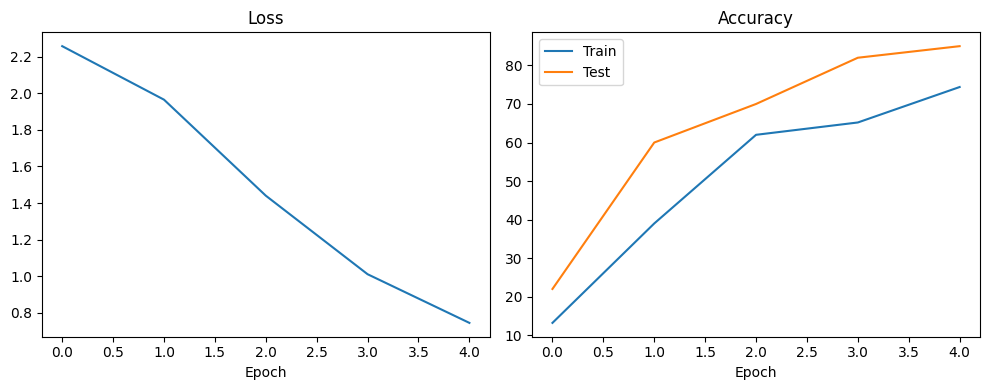

In [7]:
result = train_cnn(mnist)
print(f"\nMock accuracy: {result.public['test_accuracy']:.2f}%")
result.show_figures("public")

In [8]:
result.request_private()
print("Request sent! Run DO notebook Steps 5-8...")

📨 Sending computation request to client1@sandbox.local
   Function: train_cnn
   Result: result
✓ Sent to /Users/madhavajay/dev/biovault-desktop/workspace2/biovault/sandbox/client2@sandbox.local/datasites/client2@sandbox.local/shared/biovault/sessions/d9efe11cc2d0/f43c6cb545c544739e7b4faa9ee2e3da.beaver
💡 Result will auto-update when client1@sandbox.local approves
Request sent! Run DO notebook Steps 5-8...


## Step 5: Monitor Progress & Receive Results

In [9]:
# Monitor training progress
progress = session.wait_for_remote_var("training_progress", timeout=60)
if progress:
    print("Monitoring training progress...")
    print("-" * 40)
    last_status = None
    for _ in range(120):
        progress = session.peer_remote_vars["training_progress"].load(inject=False, auto_accept=True)
        p = progress.public
        status = p.get('status', '')
        
        if status != last_status:
            if status == 'waiting':
                print("⏳ Waiting for training to start...")
            elif status == 'training':
                print("🚀 Training in progress...")
            elif status == 'complete':
                print(f"✅ Complete! Train={p.get('train_acc', 0):.1f}%, Test={p.get('test_acc', 0):.1f}%")
                break
            last_status = status
        
        time.sleep(1)
    print("-" * 40)

⏳ Waiting for 'training_progress' from client1@sandbox.local...
📬 'training_progress' is now available!
🟢 Live sync enabled (read-only, every 0.5s)
✓ Loaded Twin 'training_progress' from published location
Monitoring training progress...
----------------------------------------
🟢 Live sync enabled (read-only, every 0.5s)
⏳ Waiting for training to start...
🟢 Live sync enabled (read-only, every 0.5s)
🟢 Live sync enabled (read-only, every 0.5s)
🚀 Training in progress...
🟢 Live sync enabled (read-only, every 0.5s)
🟢 Live sync enabled (read-only, every 0.5s)
🟢 Live sync enabled (read-only, every 0.5s)
🟢 Live sync enabled (read-only, every 0.5s)
🟢 Live sync enabled (read-only, every 0.5s)
🟢 Live sync enabled (read-only, every 0.5s)
🟢 Live sync enabled (read-only, every 0.5s)
🟢 Live sync enabled (read-only, every 0.5s)
🟢 Live sync enabled (read-only, every 0.5s)
🟢 Live sync enabled (read-only, every 0.5s)
🟢 Live sync enabled (read-only, every 0.5s)
🟢 Live sync enabled (read-only, every 0.5s)


In [10]:
session.inbox()

InboxView(/Users/madhavajay/dev/biovault-desktop/workspace2/biovault/sandbox/client2@sandbox.local/datasites/client1@sandbox.local/shared/biovault/sessions/d9efe11cc2d0): empty

In [11]:
approved = bv.wait_for_response(result, timeout=600)
print(f"\nReal Test Accuracy: {approved.private['test_accuracy']:.2f}%")
approved.show_figures("private")

⏳ Waiting for response to 'train_cnn_result'...
   Looking for reply_to: 470206746e4d...
   Watching: ['/Users/madhavajay/dev/biovault-desktop/workspace2/biovault/sandbox/client2@sandbox.local/datasites/client2@sandbox.local/shared/biovault', '/Users/madhavajay/dev/biovault-desktop/workspace2/biovault/sandbox/client2@sandbox.local/datasites/client1@sandbox.local/shared/biovault/sessions/d9efe11cc2d0', '/Users/madhavajay/dev/biovault-desktop/workspace2/biovault/sandbox/client2@sandbox.local/datasites/client1@sandbox.local/shared/biovault']
📬 Response received for 'train_cnn_result'
   From: client1@sandbox.local
✅ 'train_cnn_result' updated with result

Real Test Accuracy: 97.30%
📊 No private figures captured


In [12]:
# Compare mock vs real results
print("=== Mock vs Real ===")
print(f"Mock: {result.public['test_accuracy']:.2f}%")
print(f"Real: {approved.private['test_accuracy']:.2f}%")
print(f"\nModel received: {len(approved.private.get('model_weights', b''))} bytes")

=== Mock vs Real ===
Mock: 85.00%
Real: 97.30%

Model received: 1687168 bytes


## Step 6: Load and Test the Trained Model

The DO sent us the trained model weights. Let's load and verify it works!

In [13]:
# Load the trained model from safetensors bytes
import torch
import torch.nn as nn
from safetensors.torch import load_model
import tempfile
import os

# Define the same CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(self.relu(self.fc1(x)))
        return self.fc2(x)

# Load model weights
model_bytes = approved.private.get('model_weights', b'')
if model_bytes:
    # Write bytes to temp file and load
    with tempfile.NamedTemporaryFile(suffix='.safetensors', delete=False) as f:
        f.write(model_bytes)
        temp_path = f.name
    
    trained_model = CNN()
    load_model(trained_model, temp_path)
    os.unlink(temp_path)
    
    trained_model.eval()
    print(f"✓ Model loaded: {sum(p.numel() for p in trained_model.parameters())} parameters")
else:
    print("No model weights received")

✓ Model loaded: 421642 parameters


In [14]:
# Test the model on our mock data to verify it works
from torch.utils.data import DataLoader, TensorDataset

# Get our mock test data
mock_X_test = torch.tensor(np.array(mnist.public['X_test']), dtype=torch.float32).unsqueeze(1)
mock_y_test = torch.tensor(np.array(mnist.public['y_test']), dtype=torch.long)

test_loader = DataLoader(TensorDataset(mock_X_test, mock_y_test), batch_size=32)

# Run inference
trained_model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = trained_model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

local_accuracy = 100. * correct / total
print(f"✅ Model verified on local mock data: {local_accuracy:.2f}%")
print(f"\n🎉 Success! We have a trained model without ever seeing the real data!")

✅ Model verified on local mock data: 99.00%

🎉 Success! We have a trained model without ever seeing the real data!


## Summary

In this tutorial you:

1. **Defined CNN architecture** - Same model runs on both mock and real data
2. **Tested on mock data** - Verified function works before sending to DO
3. **Monitored live progress** - Watched epoch-by-epoch accuracy in real-time
4. **Received trained model** - Got model weights via safetensors
5. **Verified locally** - Ran inference on mock data to confirm model works

### Privacy Preserved!

- You received training curves and accuracy metrics
- You received the **trained model weights**
- You did **NOT** receive the raw MNIST images
- DO controlled what was shared at every step